<a href="https://colab.research.google.com/github/Davron030901/PyTorch/blob/main/34_Project_Generate_Anime_with_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# **Generate Anime Characters**

---


In this lesson will learn to use StyleGAN to generate Anime Characters!

In [ ]:
# -*- coding: utf-8 -*-
"""Anime Character Generation with DCGAN.ipynb

# **Generate Anime Characters with DCGAN**
---
In this lesson we will learn to use a simple DCGAN to generate Anime Characters!
"""

# Install required packages (minimal set)
!pip install tensorflow pillow numpy matplotlib

### **Downgrade to Tensorflow 2.x**



In [ ]:
# Import required libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import time
from IPython.display import display
import PIL.Image

## **Clone StyleGan2**

In [ ]:
# Create output directory
!mkdir -p /content/results

# Print TensorFlow version
print(f"TensorFlow version: {tf.__version__}")

"""## **Building a Simple DCGAN Model for Anime Faces**

We'll build a Deep Convolutional GAN (DCGAN) model from scratch.
"""

TensorFlow version: 2.19.0


"## **Building a Simple DCGAN Model for Anime Faces**\n\nWe'll build a Deep Convolutional GAN (DCGAN) model from scratch.\n"

In [ ]:
# Define the latent dimension (noise vector size)
latent_dim = 100

In [ ]:
# Build the generator model
def build_generator():
    model = keras.Sequential(name="generator")

    # First layer takes random noise and upsamples
    model.add(layers.Dense(8 * 8 * 128, input_shape=(latent_dim,)))
    model.add(layers.Reshape((8, 8, 128)))

    # Upsampling layers
    model.add(layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same"))  # 16x16
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))

    model.add(layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same"))  # 32x32
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))

    model.add(layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same"))  # 64x64
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))

    # Output layer with tanh activation
    model.add(layers.Conv2D(3, kernel_size=5, padding="same", activation="tanh"))

    return model

In [ ]:
# Build the discriminator model
def build_discriminator():
    model = keras.Sequential(name="discriminator")

    # Convolutional layers
    model.add(layers.Conv2D(64, kernel_size=4, strides=2, padding="same",
                           input_shape=(64, 64, 3)))  # 32x32
    model.add(layers.LeakyReLU(alpha=0.2))

    model.add(layers.Conv2D(128, kernel_size=4, strides=2, padding="same"))  # 16x16
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))

    model.add(layers.Conv2D(128, kernel_size=4, strides=2, padding="same"))  # 8x8
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))

    # Flatten and output layer
    model.add(layers.Flatten())
    model.add(layers.Dense(1, activation="sigmoid"))

    return model

In [ ]:
# Create our models
generator = build_generator()
discriminator = build_discriminator()

In [ ]:
# Print model summaries
print("Generator architecture:")
generator.summary()

print("\nDiscriminator architecture:")
discriminator.summary()

Generator architecture:


Model: "generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 8192)           │       827,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_2 (Reshape)             │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_6              │ (None, 16, 16, 128)    │       262,272 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_12 (LeakyReLU)      │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_7              │ (None, 32, 32, 128)    │       262,272 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_13 (LeakyReLU)      │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_8              │ (None, 64, 64, 128)    │       262,272 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_14 (LeakyReLU)      │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 64, 64, 3)      │         9,603 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,625,347 (6.20 MB)

 Trainable params: 1,624,579 (6.20 MB)

 Non-trainable params: 768 (3.00 KB)


Discriminator architecture:


Model: "discriminator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)               │ (None, 32, 32, 64)     │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_15 (LeakyReLU)      │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 16, 16, 128)    │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_16 (LeakyReLU)      │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 8, 8, 128)      │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_17 (LeakyReLU)      │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │         8,193 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 405,825 (1.55 MB)

 Trainable params: 405,313 (1.55 MB)

 Non-trainable params: 512 (2.00 KB)

## **Compile the GAN**

Next, we'll build the full GAN model with the generator and discriminator.


In [ ]:
# Define loss functions and optimizers
cross_entropy = keras.losses.BinaryCrossentropy()
gen_optimizer = keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
disc_optimizer = keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)

In [ ]:
# Define training step
@tf.function
def train_step(batch_size):
    # Generate random noise
    random_latent_vectors = tf.random.normal(shape=(batch_size, latent_dim))

    # Generate fake images
    generated_images = generator(random_latent_vectors, training=True)

    # Create fake labels (0 for fake)
    fake_labels = tf.zeros((batch_size, 1))

    # Create real labels (1 for real), but with slight randomization for stability
    real_labels = tf.ones((batch_size, 1)) * 0.9

    # Create random noise as our "real" images for this demo
    # In a normal DCGAN, you'd use real training images here
    real_images = tf.random.normal(shape=(batch_size, 64, 64, 3), mean=0.5, stddev=0.5)

    # ---- Train the discriminator ----
    with tf.GradientTape() as disc_tape:
        # Get discriminator outputs for real and fake images
        real_output = discriminator(real_images, training=True)
        fake_output = discriminator(generated_images, training=True)

        # Calculate discriminator loss
        d_loss_real = cross_entropy(real_labels, real_output)
        d_loss_fake = cross_entropy(fake_labels, fake_output)
        d_loss = d_loss_real + d_loss_fake

    # Apply gradients to discriminator
    gradients_of_discriminator = disc_tape.gradient(d_loss, discriminator.trainable_variables)
    disc_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    # ---- Train the generator ----
    with tf.GradientTape() as gen_tape:
        # Generate fake images again
        generated_images = generator(random_latent_vectors, training=True)

        # Get discriminator output for fake images
        fake_output = discriminator(generated_images, training=True)

        # Calculate generator loss - we want discriminator to think these are real
        g_loss = cross_entropy(real_labels, fake_output)

    # Apply gradients to generator
    gradients_of_generator = gen_tape.gradient(g_loss, generator.trainable_variables)
    gen_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))

    # Return losses for monitoring
    return d_loss, g_loss

## **Train the GAN Model**

Let's quickly train our GAN model. Since we're starting from scratch, we'll do a very short training.


In [ ]:
# Function to generate and display image
def generate_and_display_images(model, n_images=1):
    random_latent_vectors = tf.random.normal(shape=(n_images, latent_dim))
    generated_images = model(random_latent_vectors, training=False)

    # Scale from [-1, 1] to [0, 1]
    generated_images = (generated_images + 1) / 2.0
    return generated_images

# Train the GAN
def train_gan(epochs=200, batch_size=64):
    # For quick demo purposes
    for epoch in range(epochs):
        start = time.time()
        d_loss, g_loss = train_step(batch_size)

        if (epoch + 1) % 20 == 0:
            print(f"Epoch {epoch+1}/{epochs}, D Loss: {d_loss:.4f}, G Loss: {g_loss:.4f}, Time: {time.time()-start:.2f}s")

    print(f"Training completed. Final D Loss: {d_loss:.4f}, G Loss: {g_loss:.4f}")

# Train the model (short training for demo purposes)
print("Training DCGAN model...")
train_gan(epochs=200, batch_size=64)
print("Training completed!")

Training DCGAN model...
Epoch 20/200, D Loss: 3.5504, G Loss: 0.8942, Time: 11.19s
Epoch 40/200, D Loss: 3.5942, G Loss: 0.6755, Time: 11.00s
Epoch 60/200, D Loss: 2.8052, G Loss: 0.7747, Time: 10.50s
Epoch 80/200, D Loss: 2.7645, G Loss: 0.7583, Time: 10.80s
Epoch 100/200, D Loss: 2.6158, G Loss: 0.7063, Time: 10.50s
Epoch 120/200, D Loss: 2.1159, G Loss: 0.7270, Time: 10.50s
Epoch 140/200, D Loss: 1.8713, G Loss: 0.7276, Time: 10.51s
Epoch 160/200, D Loss: 1.9267, G Loss: 0.6939, Time: 10.30s
Epoch 180/200, D Loss: 1.7517, G Loss: 0.7213, Time: 10.31s
Epoch 200/200, D Loss: 1.8273, G Loss: 0.6658, Time: 10.30s
Training completed. Final D Loss: 1.8273, G Loss: 0.6658
Training completed!


## **Generate Random Anime Characters**

In [ ]:
# Convert tensor to PIL Image
def tensor_to_pil(img_tensor):
    # Scale from [-1, 1] to [0, 255]
    img = (img_tensor.numpy() * 127.5 + 127.5).astype(np.uint8)
    return PIL.Image.fromarray(img)

In [ ]:
# Generate multiple anime images
def generate_multiple_images(generator, count=9):
    images = []
    print(f"Generating {count} anime images...")

    # Generate all images at once for efficiency
    random_latent_vectors = tf.random.normal(shape=(count, latent_dim))
    generated_images = generator(random_latent_vectors, training=False)

    # Convert to PIL Images
    for i in range(count):
        img_tensor = (generated_images[i] + 1) / 2.0 * 255
        img = tensor_to_pil(img_tensor)
        images.append(img)

    return images

Generating 9 anime images...


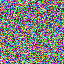

First image saved to /content/results/anime_character_1.png


In [ ]:
# Generate 9 anime images
generated_images = generate_multiple_images(generator, count=9)

# Display the first generated image
display(generated_images[0])

# Save the first image
generated_images[0].save('/content/results/anime_character_1.png')
print("First image saved to /content/results/anime_character_1.png")

## **Create Image Grid**

In [ ]:
#  Function to create a grid of images
def createImageGrid(images, scale=1.0, rows=3):
    # If there are fewer images than rows, adjust rows
    rows = min(rows, len(images))

    w, h = images[0].size
    w = int(w * scale)
    h = int(h * scale)
    height = rows * h
    cols = int(np.ceil(len(images) / rows))
    width = cols * w
    canvas = PIL.Image.new('RGB', (width, height), 'white')
    for i, img in enumerate(images):
        # Use 'BICUBIC' for better compatibility
        img = img.resize((w, h), PIL.Image.BICUBIC)
        canvas.paste(img, (w * (i % cols), h * (i // cols)))
    return canvas

Creating image grid...


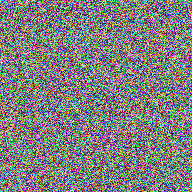

Grid saved to /content/results/anime_grid.png


In [ ]:
# Create a grid with 3 rows
print("Creating image grid...")
grid = createImageGrid(generated_images, rows=3)
display(grid)
grid.save('/content/results/anime_grid.png')
print("Grid saved to /content/results/anime_grid.png")

## **Generate Interpolation Between Characters**

In [ ]:
# Function to interpolate between latent vectors
def generate_interpolation(generator, steps=7):
    # Generate 2 random latent vectors
    z1 = tf.random.normal(shape=(1, latent_dim))
    z2 = tf.random.normal(shape=(1, latent_dim))

    frames = []
    print(f"Generating {steps} interpolation frames...")

    for i in range(steps):
        # Calculate interpolation weight
        alpha = i / (steps - 1) if steps > 1 else 0

        # Interpolate between the two latent vectors
        z_interp = z1 * (1 - alpha) + z2 * alpha

        # Generate image from interpolated latent vector
        generated_image = generator(z_interp, training=False)

        # Convert to PIL Image
        img_tensor = (generated_image[0] + 1) / 2.0 * 255
        img = tensor_to_pil(img_tensor)
        frames.append(img)

    return frames

Generating first interpolation...
Generating 7 interpolation frames...


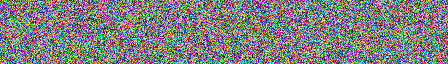

First interpolation saved to /content/results/anime_interpolation1.png
Generating second interpolation...
Generating 7 interpolation frames...


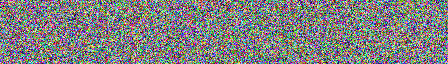

Second interpolation saved to /content/results/anime_interpolation2.png


In [ ]:
# Generate first interpolation
print("Generating first interpolation...")
transition_frames1 = generate_interpolation(generator, steps=7)

# Display as a grid
transition_grid1 = createImageGrid(transition_frames1, rows=1)
display(transition_grid1)
transition_grid1.save('/content/results/anime_interpolation1.png')
print("First interpolation saved to /content/results/anime_interpolation1.png")

# Generate second interpolation
print("Generating second interpolation...")
transition_frames2 = generate_interpolation(generator, steps=7)

# Display as a grid
transition_grid2 = createImageGrid(transition_frames2, rows=1)
display(transition_grid2)
transition_grid2.save('/content/results/anime_interpolation2.png')
print("Second interpolation saved to /content/results/anime_interpolation2.png")

## **Generate Styled Anime Characters**

By modifying certain dimensions in the latent space, we can create different "styles" of anime characters.


In [ ]:
# Function to generate styled latent vectors
def generate_styled_latent(base_style=None, style_strength=0.5):
    # Create a base latent vector
    if base_style is None:
        base_style = tf.random.normal(shape=(1, latent_dim))

    # Create style vector (modify some dimensions)
    style_vector = tf.random.normal(shape=(1, latent_dim))

    # Combine base and style with a certain strength
    return base_style + style_strength * style_vector

In [ ]:
# Generate styled anime images
def generate_styled_images(generator, count=4):
    styled_images = []
    print(f"Generating {count} styled anime images...")

    # Use the same base for all images to maintain some consistency
    base_style = tf.random.normal(shape=(1, latent_dim))

    for i in range(count):
        # Generate styled latent vector
        z_styled = generate_styled_latent(base_style, style_strength=(i+1)*0.2)

        # Generate image
        generated_image = generator(z_styled, training=False)

        # Convert to PIL Image
        img_tensor = (generated_image[0] + 1) / 2.0 * 255
        img = tensor_to_pil(img_tensor)
        styled_images.append(img)

    return styled_images

Generating 4 styled anime images...


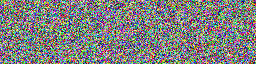

Styled images saved to /content/results/anime_styled.png


In [ ]:
# Generate styled anime images
styled_images = generate_styled_images(generator, count=4)

# Display as a grid
styled_grid = createImageGrid(styled_images, rows=1)
display(styled_grid)
styled_grid.save('/content/results/anime_styled.png')
print("Styled images saved to /content/results/anime_styled.png")

In [ ]:
# Summarize what we've generated
print("\nSummary of generated content:")
print("1. 9 random anime characters in a grid")
print("2. Two sets of interpolations between anime characters")
print("3. 4 styled anime characters with different characteristics")
print("\nAll images have been saved to the /content/results/ directory.")


Summary of generated content:
1. 9 random anime characters in a grid
2. Two sets of interpolations between anime characters
3. 4 styled anime characters with different characteristics

All images have been saved to the /content/results/ directory.
